### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from **MUSEUM IMAGEs**. 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Import packages

In [3]:
from fastai import *
from fastai.vision import *
from fastai.widgets import ClassConfusion # to find model weaknesses

In [4]:
np.random.seed(1138)

Now prepare to download the files to our repo

In [5]:
mimage_path = "../data/images/Museum"

Nar

In [6]:
# Nar_folder = "Nar"
# Nar_file = "Nar_photos.txt"
# Nar_path = Path('../data/images/Museum/Nar')
# Nar_dest = Nar_path/Nar_folder
# Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [7]:
# Nmi_folder = "Nmi"
# Nmi_file = "Nmi_photos.txt"
# Nmi_path = Path('../data/images/Museum/Nmi')
# Nmi_dest = Nmi_path/Nmi_folder
# Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [8]:
# Nfr_folder = "Nfr"
# Nfr_file = "Nfr_photos.txt"
# Nfr_path = Path('../data/images/Museum/Nfr')
# Nfr_dest = Nfr_path/Nfr_folder
# Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [9]:
# Nhe_folder = "Nhe"
# Nhe_file = "Nhe_photos.txt"
# Nhe_path = Path('../data/images/Museum/Nhe')
# Nhe_dest = Nhe_path/Nhe_folder
# Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [10]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [11]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

Commenting the original code while I mess with the progressive resizing

In [12]:
transforms = get_transforms(flip_vert = True, max_warp = 0.1, \
                            max_zoom = 1.05, )

In [13]:
data_64 = ImageDataBunch.from_folder(path = mimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = transforms,
                                        size = 64, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [14]:
data_64

ImageDataBunch;

Train: LabelList (1165 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images/Museum;

Valid: LabelList (291 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nmi,Nhe,Nmi,Nar,Nmi
Path: ../data/images/Museum;

Test: None

In [15]:
print(data_64.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


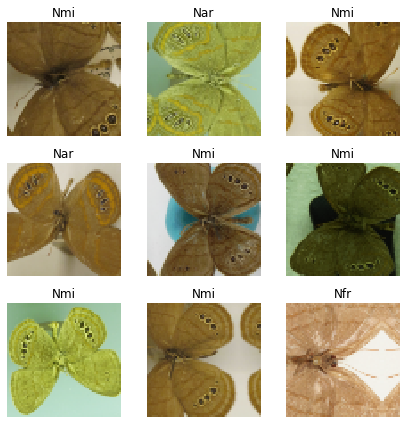

In [16]:
data_64.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [17]:
# with 64 sized images
learn_rn34 = cnn_learner(data_64, \
                            models.resnet34, \
                            metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:08<00:00, 10.6MB/s]


In [18]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


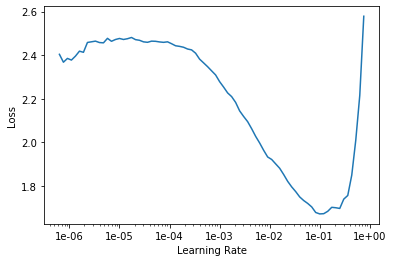

In [19]:
learn_rn34.recorder.plot()

In [20]:
learn_rn34.fit_one_cycle(5, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of 12-15% after 5 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.469864,1.000485,0.237113,00:40
1,1.110168,0.812840,0.213058,00:39
2,0.871895,0.481803,0.161512,00:40
3,0.733718,0.295216,0.147766,00:40
4,0.622062,0.305596,0.151203,00:39


In [21]:
learn_rn34.save('aug_stage_1_64_rn34')

In [22]:
#learn_rn34.load('aug_stage_1_64_rn34')

### Now the progressive augmentation

In [23]:
data_128 = ImageDataBunch.from_folder(path = mimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 128, num_workers = 4, \
                                      bs = 64).normalize(imagenet_stats)

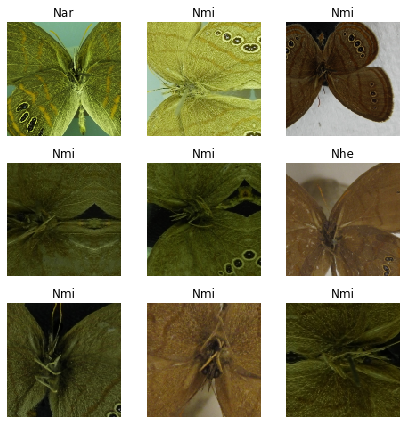

In [24]:
data_128.show_batch(rows = 3, figsize = (6, 6))

In [25]:
learn_rn34.unfreeze()
learn_rn34.data = data_128
learn_rn34.freeze()

In [26]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


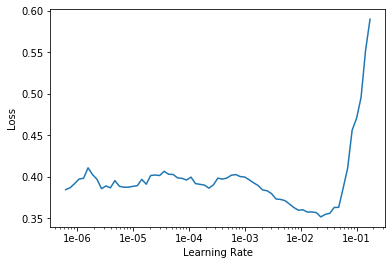

In [27]:
learn_rn34.recorder.plot()

In [28]:
learn_rn34.fit_one_cycle(3, max_lr = slice(1e-03, 1e-02)) # 8% after 2 epochs

epoch,train_loss,valid_loss,error_rate,time
0,0.416954,0.268608,0.116838,00:40
1,0.385332,0.239248,0.109966,00:41
2,0.326389,0.248552,0.116838,00:39


In [29]:
learn_rn34.save('aug_stage_2_128_rn34') 

#### 256 images

In [30]:
data_256 = ImageDataBunch.from_folder(path = mimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 256, num_workers = 4, \
                                      bs = 32).normalize(imagenet_stats)

In [31]:
learn_rn34.unfreeze()
learn_rn34.data = data_256
learn_rn34.freeze()

In [32]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


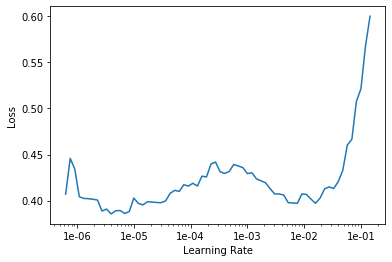

In [33]:
learn_rn34.recorder.plot()

In [34]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.309857,0.318615,0.106529,00:44
1,0.289028,0.225989,0.092784,00:43
2,0.269356,0.178088,0.079038,00:44
3,0.221469,0.169474,0.068729,00:43


In [35]:
learn_rn34.save('aug_stage_3_256_rn34')

#### Examine problem areas

In [36]:
# It is OK for train loss to be lower than valid loss. That is what you want.
# As long as you are training and error is improving you are not overfitting.

In [37]:
interpretation_34 = ClassificationInterpretation.from_learner(learn_rn34)

losses_34, idxs_34 = interpretation_34.top_losses()

len(data_256.valid_ds) == len(losses_34) == len(idxs_34)

True

In [40]:
interpretation_34.plot_top_losses(6, figsize = (11, 11))

TypeError: _cl_int_plot_top_losses() got an unexpected keyword argument 'figsize'

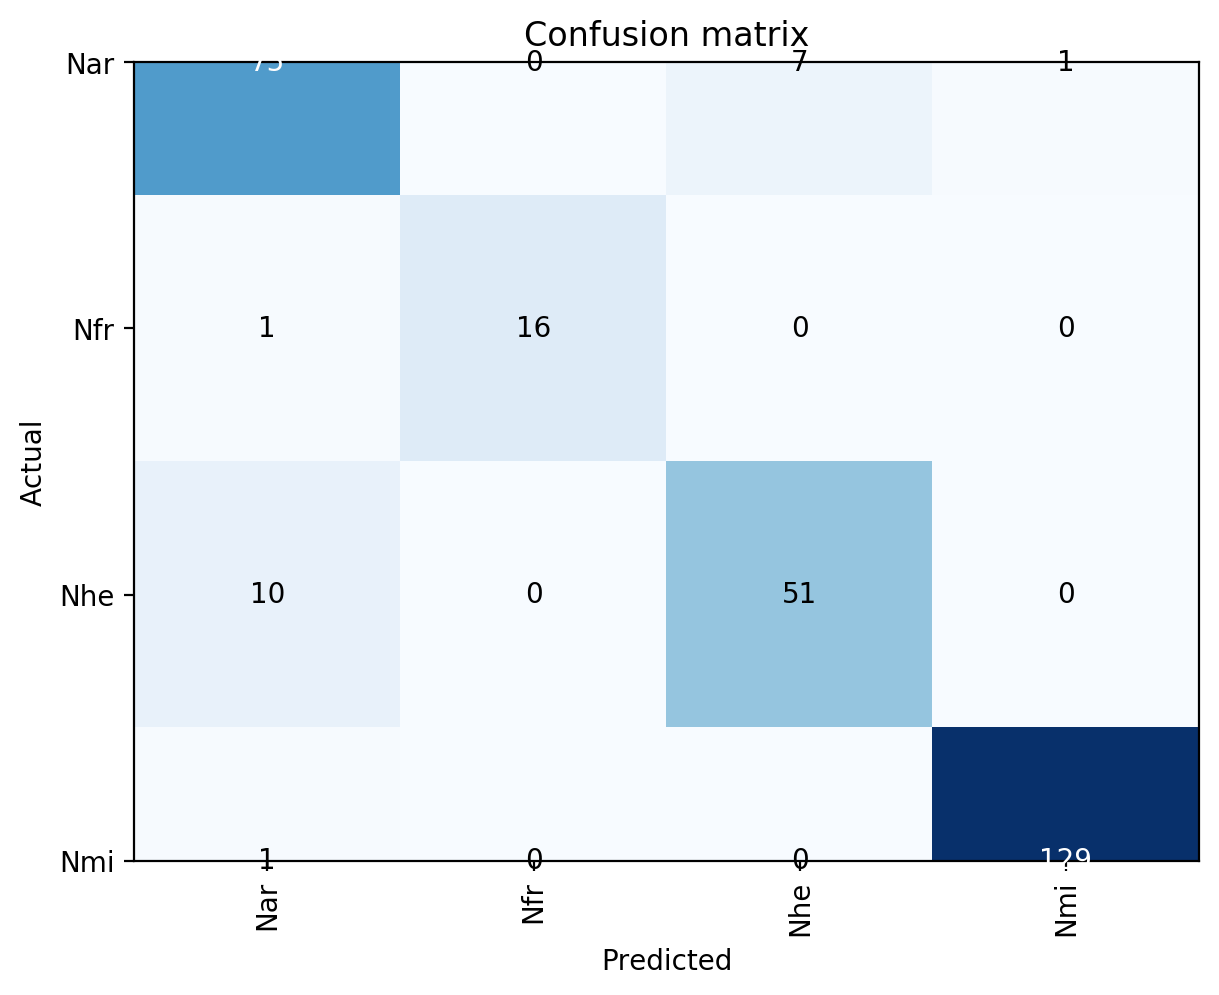

In [41]:
interpretation_34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [42]:
interpretation_34.most_confused(min_val = 0) 

[('Nhe', 'Nar', 10),
 ('Nar', 'Nhe', 7),
 ('Nar', 'Nmi', 1),
 ('Nfr', 'Nar', 1),
 ('Nmi', 'Nar', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nfr', 'Nmi', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]

In [43]:
# !pip install google.colab

     |████████████████████████████████| 81kB 3.9MB/s eta 0:00:01
     |████████████████████████████████| 71kB 6.9MB/s eta 0:00:011
     |████████████████████████████████| 112kB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 768kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 8.0MB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 11.7MB/s eta 0:00:01
     |████████████████████████████████| 491kB 10.5MB/s eta 0:00:01
     |████████████████████████████████| 51kB 12.1MB/s eta 0:00:01
     |████████████████████████████████| 163kB 12.5MB/s eta 0:00:01
     |████████████████████████████████| 245kB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 81kB 11.9MB/s eta 0:00:01


  Created wheel for google.colab: filename=google_colab-1.0.0-py2.py3-none-any.whl size=102291 sha256=de136bdb8550de94c2611180c891791a14c3adbc834d2f118b222edcf0b99b56
  Stored in directory: /root/.cache/pip/wheels/38/0d/59/701e300a337b2a2e07b27fe74dbfff0bc56ac58f711566ee67
  Created wheel for portpicker: filename=portpicker-1.2.0-cp36-none-any.whl size=13367 sha256=541a74fa1746027f52de4c6bc52084cd1aafb269d07557b2eeecf66453a540af
  Stored in directory: /root/.cache/pip/wheels/4a/45/47/1e126be9d4605e71f00d6e6fb151611f2f4cb9770b050c7d2d
  Created wheel for tornado: filename=tornado-4.5.3-cp36-cp36m-linux_x86_64.whl size=433136 sha256=77612cc99fc2df3dc3a0ea33647e9c6b6d946faaa2a2c0011ec1a32f96a221f0
  Stored in directory: /root/.cache/pip/wheels/72/bf/f4/b68fa69596986881b397b18ff2b9af5f8181233aadcc9f76fd
  Created wheel for simplegeneric: filename=simplegeneric-0.8.1-cp36-none-any.whl size=5076 sha256=6993cbc710c79ef6b18ada906b3b5defdb9d65d586d2cd6dc94ee1499913acd8
  Stored in directory: /r

In [ ]:
import math
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from itertools import permutations
from fastai.train import ClassificationInterpretation
from google.colab import widgets

class ClassConfusion():
    "Plot the most confused datapoints and statistics for the models misses." 
    def __init__(self, interp:ClassificationInterpretation, classlist:list, 
               is_ordered:bool=False, cut_off:int=100, varlist:list=None,
               figsize:tuple=(8,8)):
        self.interp = interp
        self._is_tab = (str(type(interp.learn.data)) == "<class 'fastai.tabular.data.TabularDataBunch'>")
        if self._is_tab:
            if interp.learn.data.train_ds.x.cont_names != []: 
                for x in range(len(interp.learn.data.procs)):
                      if "Normalize" in str(interp.learn.data.procs[x]):
                            self.means = interp.learn.data.train_ds.x.processor[0].procs[x].means
                            self.stds = interp.learn.data.train_ds.x.processor[0].procs[x].stds
        self.is_ordered = is_ordered
        self.cut_off = cut_off
        self.figsize = figsize
        self.classl = classlist
        self.varlist = varlist
        self._show_losses(classlist)            

    def _show_losses(self, classl:list, **kwargs):
        "Checks if the model is for Tabular or Images and gathers top losses"
        _, self.tl_idx = self.interp.top_losses(len(self.interp.losses))
        self._tab_losses() if self._is_tab else self._create_tabs()
        
    def _create_tabs(self):
        "Creates a tab for each variable"
        self.lis = self.classl if self.is_ordered else list(permutations(self.classl, 2))
        if self._is_tab:
            self._boxes = len(self.df_list)
            self._cols = math.ceil(math.sqrt(self._boxes))
            self._rows = math.ceil(self._boxes/self._cols)
            self.tbnames = list(self.df_list[0].columns)[:-1] if self.varlist is None else self.varlist
        else:
            vals = self.interp.most_confused()
            self._ranges = []
            self.tbnames = []
            self._boxes = int(input('Please enter a value for `k`, or the top images you will see: '))
            for x in iter(vals):
                for y in range(len(self.lis)):
                    if x[0:2] == self.lis[y]:
                        self._ranges.append(x[2])
                        self.tbnames.append(str(x[0] + ' | ' + x[1]))

        self.tb = widgets.TabBar(self.tbnames)
        self._populate_tabs()
        
    def _populate_tabs(self):
        "Adds relevant graphs to each tab"
        with tqdm(total=len(self.tbnames)) as pbar:
            for i, tab in enumerate(self.tbnames):
                with self.tb.output_to(i):
                    self._plot_tab(tab) if self._is_tab else self._plot_imgs(tab, i)
            pbar.update(1)

    def _plot_imgs(self, tab:str, i:int ,**kwargs):
        "Plots the most confused images"
        classes_gnd = self.interp.data.classes
        x = 0
        if self._ranges[i] < self._boxes:
            cols = math.ceil(math.sqrt(self._ranges[i]))
            rows = math.ceil(self._ranges[i]/cols)

        if self._ranges[i] < 4 or self._boxes < 4:
            cols = 2
            rows = 2
        else:
            cols = math.ceil(math.sqrt(self._boxes))
            rows = math.ceil(self._boxes/cols)
        fig, ax = plt.subplots(rows, cols, figsize=self.figsize)

        [axi.set_axis_off() for axi in ax.ravel()]
        for j, idx in enumerate(self.tl_idx):
            if self._boxes < x+1 or x > self._ranges[i]:
                break
            da, cl = self.interp.data.dl(self.interp.ds_type).dataset[idx]
            row = (int)(x / cols)
            col = x % cols

            ix = int(cl)
            if str(cl) == tab.split(' ')[0] and str(classes_gnd[self.interp.pred_class[idx]]) == tab.split(' ')[2]:
                img, lbl = self.interp.data.valid_ds[idx]
                fn = self.interp.data.valid_ds.x.items[idx]
                #fn = re.search('([^/*]+)_\d+.*$', str(fn)).group(0)
                img.show(ax=ax[row, col])
                ax[row,col].set_title(fn)
                x += 1
        plt.show(fig)
        plt.tight_layout()

    def _plot_tab(self, tab:str):
        "Generates graphs"
        if self._boxes is not None:
            fig, ax = plt.subplots(self._boxes, figsize=self.figsize)
        else:
            fig, ax = plt.subplots(self._cols, self._rows, figsize=self.figsize)
        fig.subplots_adjust(hspace=.5)
        for j, x in enumerate(self.df_list):
            title = f'{"".join(x.columns[-1])} {tab} distribution'
            if self._boxes is None:
                row = int(j / self._cols)
                col = j % row
            if tab in self.cat_names:
                vals = pd.value_counts(x[tab].values)
                if self._boxes is not None:
                    if vals.nunique() < 10:
                        fig = vals.plot(kind='bar', title=title,  ax=ax[j], rot=0, width=.75)
                    elif vals.nunique() > self.cut_off:
                        print(f'Number of values is above {self.cut_off}')
                    else:
                        fig = vals.plot(kind='barh', title=title,  ax=ax[j], width=.75)   
                else:
                    fig = vals.plot(kind='barh', title=title,  ax=ax[row, col], width=.75)
            else:
                vals = x[tab]
                if self._boxes is not None:
                    axs = vals.plot(kind='hist', ax=ax[j], title=title, y='Frequency')
                else:
                    axs = vals.plot(kind='hist', ax=ax[row, col], title=title, y='Frequency')
                axs.set_ylabel('Frequency')
                if len(set(vals)) > 1:
                    vals.plot(kind='kde', ax=axs, title=title, secondary_y=True)
                else:
                    print('Less than two unique values, cannot graph the KDE')
        plt.show(fig)
        plt.tight_layout()
        
    def _tab_losses(self, **kwargs):
        "Gathers dataframes of the combinations data"
        classes = self.interp.data.classes
        cat_names = self.interp.data.x.cat_names
        cont_names = self.interp.data.x.cont_names
        comb = self.classl if self.is_ordered else list(permutations(self.classl,2))

        self.df_list = []
        arr = []
        for i, idx in enumerate(self.tl_idx):
            da, _ = self.interp.data.dl(self.interp.ds_type).dataset[idx]
            res = ''
            for c, n in zip(da.cats, da.names[:len(da.cats)]):
                string = f'{da.classes[n][c]}'
                if string == 'True' or string == 'False':
                    string += ';'
                    res += string

                else:
                    string = string[1:]
                    res += string + ';'
            for c, n in zip(da.conts, da.names[len(da.cats):]):
                res += f'{c:.4f};'
            arr.append(res)
        f = pd.DataFrame([ x.split(';')[:-1] for x in arr], columns=da.names)
        for i, var in enumerate(self.interp.data.cont_names):
            f[var] = f[var].apply(lambda x: float(x) * self.stds[var] + self.means[var])
        f['Original'] = 'Original'
        self.df_list.append(f)

        for j, x in enumerate(comb):
            arr = []
            for i, idx in enumerate(self.tl_idx):
                da, cl = self.interp.data.dl(self.interp.ds_type).dataset[idx]
                cl = int(cl)

                if classes[self.interp.pred_class[idx]] == comb[j][0] and classes[cl] == comb[j][1]:
                    res = ''
                    for c, n in zip(da.cats, da.names[:len(da.cats)]):
                        string = f'{da.classes[n][c]}'
                        if string == 'True' or string == 'False':
                            string += ';'
                            res += string
                        else:
                            string = string[1:]
                            res += string + ';'
                    for c, n in zip(da.conts, da.names[len(da.cats):]):
                        res += f'{c:.4f};'
                    arr.append(res)      
            f = pd.DataFrame([ x.split(';')[:-1] for x in arr], columns=da.names)
            for i, var in enumerate(self.interp.data.cont_names):
                f[var] = f[var].apply(lambda x: float(x) * self.stds[var] + self.means[var])
            f[str(x)] = str(x)
            self.df_list.append(f)
        self.cat_names = cat_names
        self._create_tabs() 

In [ ]:
ClassConfusion(interpretation_34, classes)

In [ ]:
from ClassConfusion import *

In [ ]:
ClassLosses(interpretation_34, classes)

### `resnet50`

Re run the code to generate the `data_64` object. 

In [ ]:
# with 64 sized images
learn_rn50 = cnn_learner(data_64, \
                            models.resnet50, \
                            metrics = error_rate)

Get the learning rate

In [ ]:
learn_rn50.lr_find()

In [ ]:
learn_rn50.recorder.plot()

Use the best (steepest) LR for the model

In [ ]:
learn_rn50.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~14% after 4 cycles

Save the model, fine tune, and save

In [ ]:
learn_rn50.save('stage_1_64_rn50')

In [ ]:
#learn_rn50.load('stage_1_64_rn50')

Now the progressive augmentation

In [ ]:
learn_rn50.unfreeze()
learn_rn50.data = data_128
learn_rn50.freeze()

Find the optimal learning rate

In [ ]:
learn_rn50.lr_find()

In [ ]:
learn_rn50.recorder.plot()

In [ ]:
learn_rn50.fit_one_cycle(2, max_lr = slice(1e-03, 1e-02)) # 9% error

In [ ]:
learn_rn50.save('stage_2_128_rn50')

In [ ]:
learn_rn50.unfreeze()
learn_rn50.data = data_256
learn_rn50.freeze()

In [ ]:
learn_rn50.lr_find()

In [ ]:
learn_rn50.recorder.plot()

In [ ]:
learn_rn50.fit_one_cycle(4) # 6% error

In [ ]:
learn_rn50.save('stage_3_256_rn50')

### Problem areas

In [ ]:
interpretation_50 = ClassificationInterpretation.from_learner(learn_rn50)

losses_50, idxs_50 = interpretation_50.top_losses()

len(data_128.valid_ds) == len(losses_50) == len(idxs_50)

In [ ]:
# learn_rn50.load('stage_3_128_rn50')

In [ ]:
interpretation_50.plot_top_losses(6, figsize = (15, 11))

In [ ]:
interpretation_50.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [ ]:
interpretation_50.most_confused(min_val = 0) # same problems as resnet34.